In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# import uniform distribution
from scipy.stats import uniform
from scipy.stats import binom
import scipy.special as sc
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.stats import pareto
import time
from scipy.stats import truncnorm
np.random.seed(5)

In [2]:
def auction_exp(data_auction, p):
    """auction experiment simulation

    Args:
        data_auction: random sample data for auction simulation
        p: the reserve price
        
    Return:
        revenue: the expected revenue
    """
    revenue = 0
    for bid in data_auction:
        if bid >= p:
          #change the bidder with price p
          revenue += p
    
    revenue = revenue/len(data_auction)
    return revenue

In [3]:
def rejection_sampling(pi1, pi2, N):
    """rejection sampling algorithm

    Args:
        pi1,pi2: the range of log-lottery distribution
        N: the number of samples from the log-lottery distribution
        
    Return:
        rej_sample: The random samples from the log-lottery distribution
    """

    #using rejection sampling, get N random price samples
    n = 0
    don = pi2*np.log(pi2/pi1) - (pi2-pi1)
    env =(pi2/pi1-1)/don
    rej_sample =[]
    while(n <= N):
        x = uniform.rvs(loc=pi1, scale=pi2-pi1)
        #a is acception probability
        a = (pi2/x-1)/don/env
        u1 = uniform.rvs()
        if (u1 <= a):
            rej_sample.append(x)
            n += 1
    return rej_sample

In [5]:
#This script is used to perform Experiment 2 for truncated normal distribution, 

#Azard and Micali k(r) function
def k_r(x):
    return (0.5*(3*x +x**3) -1/r_m)

#Equavelent funtion like A&M, but using consistent notation with Robust paper
def rho_tilde(x):
    return ((x-1)**3)/(x**2) - (27/4)*r_m**2 

#Deterministic DAPX from the Robust paper
def rho_D(x):
    return ((x-1)**3)/((2*x-1)**2) - r_m**2 

#Function to solve optimal resreve price for single-item auctions with truncated normal valuation distribution
def F_tnorm(x):
    return  x-((1-truncnorm.cdf(x, a , b ,loc = u,scale = sigma))/truncnorm.pdf(x, a , b ,loc = u,scale = sigma))

#Solve pi1 for the log-lottery distribution
def log_lottery(x):
    return (x * (1 + np.log(cons_m/(x**2) + 1) - np.log(2)) -u_m )


tic = time.clock()
rev_A_list = []
rev_A1_list=[]
#bundling price for Azar and Micali mechanism
p_AM = []
p_AM_list = []
p_A1_list = []
rev_A2_list = []
p_A2_list = []
u_m_list = []
DAPX = []
APX_rev_list = []
APX_tnorm_list=[]
myclip_a = 0
myclip_b = np.inf
u = 5
tic = time.clock()
step = np.arange(2, 51,1)
n = 100000
k1 = 30
#u and sigma is the shape and scale parameter
sigma = 2
#computer alpha beta for truncated normal distribution
a, b = (myclip_a - u) / sigma, myclip_b

#constant of truncated normal distribution
k = 1/(1-norm.cdf(0, loc = u,scale = sigma))
#this is the mean and variance for truncated normal distribution
mean, var = truncnorm.stats(a , b ,loc = u,scale = sigma, moments='mv')
r = np.sqrt(var)/mean
print(mean,var,r)
for m in step:
    
    bid_tnorm = []
    bid_tnorm = truncnorm.rvs(a , b , loc = u,scale = sigma,size=n)

    p_opt = fsolve(F_tnorm, mean-0.1)
    print(F_tnorm(p_opt))
    p_A1_list.append(p_opt)
    #1.Compute expected revenue for A1:selling separately with optimal reserve price
    rev_A1 = m*auction_exp(bid_tnorm,p_opt)
    rev_A1_list.append(rev_A1[0])
    
    
    #Generate randome variables Y, where Y = sum (X1,X2,...,Xm)
    j = 0
    bundlebid_tnorm = []
    while j < n:
        bid = truncnorm.rvs(a , b , loc = u,scale = sigma,size=m)
        bundlebid_tnorm.append(sum(bid))
        j += 1

    #Compute the mean and standard deviation for the convolution of the Perato(0) distributions    
    u_m = m*mean
    u_m_list.append(u_m)
    sigma_m = np.sqrt(m)*np.sqrt(var)
    r_m = sigma_m/u_m

                
##### This is direct implementation for Azard and Marcili mechanism
#     k = fsolve(k_r, [u])
#     print(k_r(k))
#     p.append(u - k*sigma)

    #2. This is equavelent to the Azard and Micali mechanism, just different notation
    # Here we obtain the expected revenue for Azard and Micali mechanism
    rho = fsolve(rho_tilde, [u_m])
    p_AM = u_m*(rho+2)/(3*rho)
    p_AM_list.append(p_AM)
    print(rho_tilde(rho))
    rev_A=auction_exp(bundlebid_tnorm,p_AM)
    rev_A_list.append(rev_A[0])
    DAPX.append(u_m/rev_A[0])
    ################################################################################################
    # 3.Here we obtain the expected revenue for A2: selling it grand bundle with optimal reserve price
    # We use discretization here
    prices = np.linspace(p_AM,u_m,k1+2)[1:] #we want k discrete values between p_AM and u_m, here we also include u_m to have a look
    rev = []
    for p in prices:
        rev.append(auction_exp(bundlebid_tnorm,p))
    #Store the highest expected revenue and corresponding reserve price    
    rev_A2 = max(rev)
    rev_A2_list.append(rev_A2[0])    
    p_A2_list.append(prices[np.argmax(rev)])
    #######################################################################################################
    #4.Experiment with the log-lottery auction
    #compute the APX using full-bundle log lottery randomization 
    cons_m = u_m**2 + sigma_m**2
    pi1 = fsolve(log_lottery, [u_m-0.1])
    pi2 = 0.5*(cons_m/pi1 +pi1)
    print(log_lottery(pi1))
    rej_sample = []
    rej_sample = rejection_sampling(pi1,pi2,10000)
    rexp_revenue_list =[]
    for rp_reserve in rej_sample:
        rexp_revenue_list.append(auction_exp(bundlebid_tnorm,rp_reserve))
  
    APX_rev = np.average(rexp_revenue_list)
    APX_rev_list.append(APX_rev)
    #Determine the experimental upper bound of APX 
    APX_tnorm_list.append(u_m/APX_rev)
    
    
toc = time.clock()
print('time: ' + str(toc-tic))    
# print('the expected revenue for Azard and Marcili: ' + str(rev_A))    
# print('the expected revenue for selling separately: ' + str(rev_A1))
# print('the expected revenue for boundle selling: ' + str(rev_A2))

C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


5.0352756509738335 3.822377373579205 0.38827866725921695
[2.80220291e-13]
[0.]
[1.77635684e-15]
[2.80220291e-13]
[3.25850458e-14]
[0.]


KeyboardInterrupt: 

In [ ]:
myclip_a = 0
myclip_b = np.inf
u = 5

step = np.arange(2, 50,1)
n = 100000
k1 = 10
#u and sigma is the shape and scale parameter
sigma = 2
#computer alpha beta for truncated normal distribution
a, b = (myclip_a - u) / sigma, myclip_b

#constant of truncated normal distribution
k = 1/(1-norm.cdf(0, loc = u,scale = sigma))
#this is the mean and variance for truncated normal distribution
mean, var = truncnorm.stats(a , b ,loc = u,scale = sigma, moments='mv')
r = np.sqrt(var)/mean
r

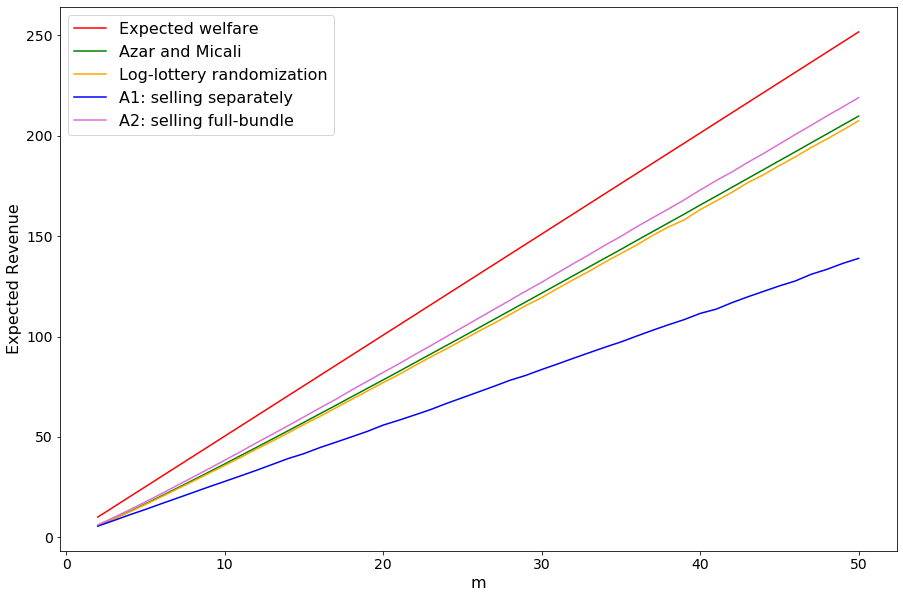

In [7]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=16)
plt.ylabel("Expected Revenue",fontsize=16)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(step, u_m_list, color="red",label="Expected welfare")
plt.plot(step, rev_A_list, color="green",label="Azar and Micali")
plt.plot(step, APX_rev_list, color="#FFA500",label="Log-lottery randomization")
plt.plot(step, rev_A1_list,color="blue",label="A1: selling separately")
plt.plot(step, rev_A2_list, color="orchid",label="A2: selling full-bundle")

plt.legend(loc="upper left",fontsize = 16)
#plt.savefig("tnormu5s2_items.png",bbox_inches='tight')

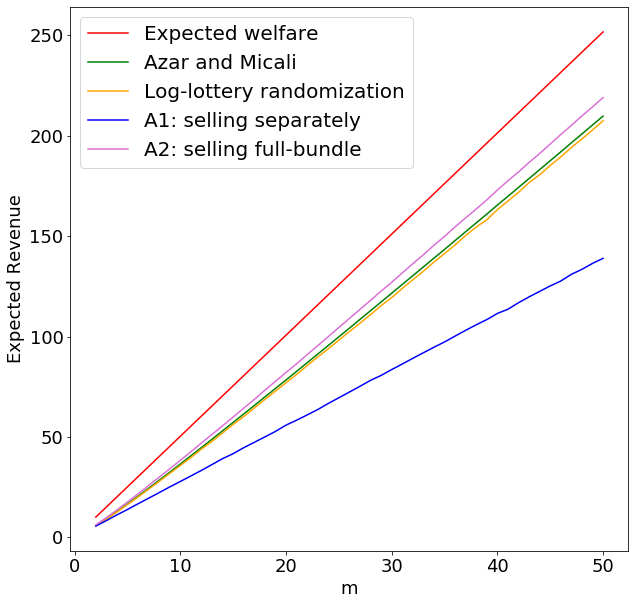

In [9]:
plt.figure(figsize=(10,10))
plt.tick_params(axis='x', labelsize= 18)
plt.tick_params(axis='y', labelsize= 18)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=18)
plt.ylabel("Expected Revenue",fontsize=18)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(step, u_m_list, color="red",label="Expected welfare")
plt.plot(step, rev_A_list, color="green",label="Azar and Micali")
plt.plot(step, APX_rev_list, color="#FFA500",label="Log-lottery randomization")
plt.plot(step, rev_A1_list,color="blue",label="A1: selling separately")
plt.plot(step, rev_A2_list, color="orchid",label="A2: selling full-bundle")

plt.legend(loc="upper left",fontsize = 20)
#plt.savefig("tnormu5s2_items_s.png",bbox_inches='tight')

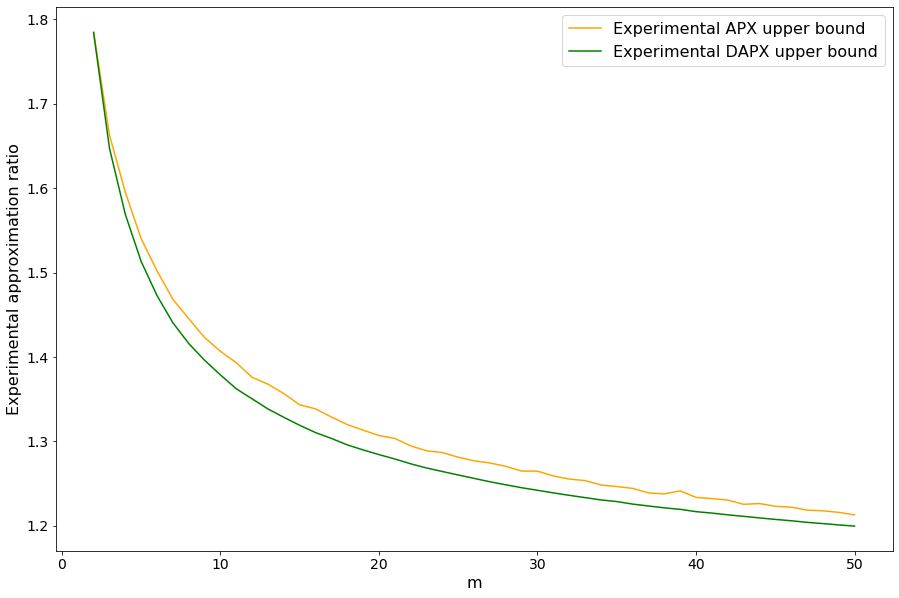

In [11]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=16)
plt.ylabel("Experimental approximation ratio",fontsize=16)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(step, APX_tnorm_list, color="#FFA500",label="Experimental APX upper bound")
plt.plot(step, DAPX, color="green",label="Experimental DAPX upper bound")

plt.legend(loc="best",fontsize = 16)
#plt.savefig("tnormu5s2_ratio.png",bbox_inches='tight')

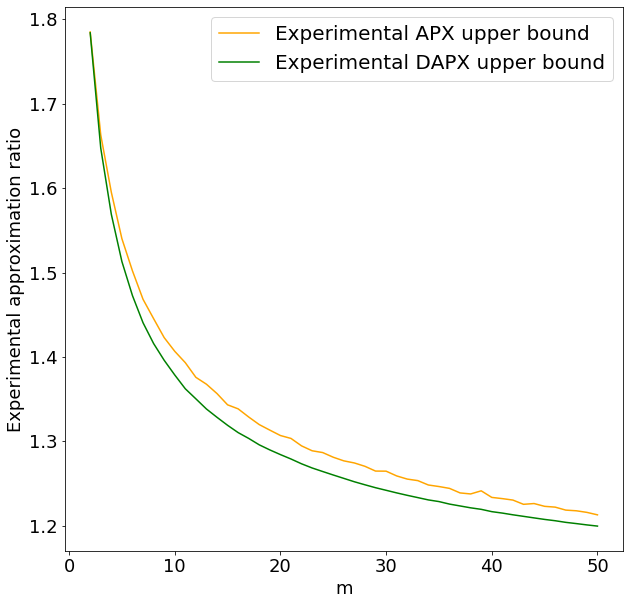

In [13]:
plt.figure(figsize=(10,10))
plt.tick_params(axis='x', labelsize= 18)
plt.tick_params(axis='y', labelsize= 18)
#ax2.axhline(0,color="red")
plt.xlabel("m",fontsize=18)
plt.ylabel("Experimental approximation ratio",fontsize=18)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(step, APX_tnorm_list, color="#FFA500",label="Experimental APX upper bound")
plt.plot(step, DAPX, color="green",label="Experimental DAPX upper bound")

plt.legend(loc="best",fontsize = 20)
#plt.savefig("tnormu5s2_ratio_s.png",bbox_inches='tight')

In [14]:
import pandas as pd 
  
# creating the DataFrame 
my_df = { 'step' : step[0],
          'u_m_list': u_m_list,
         'rev_A_list': rev_A_list,
         'APX_rev_list': APX_rev_list,
         'rev_A1_list': rev_A1_list,
         'rev_A2_list': rev_A2_list,
         'DAPX': DAPX,
         'APX_tnorm_list': APX_tnorm_list
         } 
df = pd.DataFrame(my_df) 
  
   
# saving the DataFrame as a CSV file 
gfg_csv_data = df.to_csv('tnormu5s2.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 


CSV String:
 None
